# **Transfer Learning using MobileNetV2**

Transfer learning is a powerful technique that allows sophisticated CNNs trained by Google, Microsoft, and others on GPUs to be repurposed and used to solve domain-specific problems. Many pretrained CNNs are available in the public domain, and several are included with Keras. We chose to use MobileNetV2, a pretrained CNN from Google that is optimized for mobile devices, to extract features from spectrogram images.

> MobileNetV2 requires less processing power and has a smaller memory footprint than CNNs such as ResNet50V2. That's why it is ideal for mobile devices.



In [2]:
# Importing the drive module from google.colab library
from google.colab import drive

# Mounting the Google Drive to the Colab environment
drive.mount('/content/drive')

project_path = '/content/drive/My Drive/GitHub/MarineMammalSoundClassification/'
%cd /content/drive/My Drive/GitHub/MarineMammalSoundClassification/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1oJSL58N419Ve8pd0wCvgXEy52hLM2tJN/MarineMammalSoundClassification


In [3]:
import pickle
import statistics
import numpy as np
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from tensorflow.keras import layers, models
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet import preprocess_input
import cv2

def load_data(data_path, classes_path):
    """
    Loads and preprocesses spectrogram data and class labels from pickle files.

    Parameters:
    data_path (str): Path to the pickle file containing spectrogram data.
    classes_path (str): Path to the pickle file containing class labels.

    Returns:
    tuple: A tuple containing:
        - X (np.array): Normalized spectrogram data.
        - y (np.array): One-hot encoded class labels.
        - encoder (LabelEncoder): Fitted LabelEncoder instance for decoding labels.
    """
    with open(data_path, 'rb') as f:
        X = pickle.load(f)
    with open(classes_path, 'rb') as f:
        classes = pickle.load(f)

    encoder = LabelEncoder()
    y = encoder.fit_transform(classes)
    y = to_categorical(y, num_classes=28)

    return np.array(X), np.array(y), encoder

def create_model(num_classes):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    # model.add(Flatten(input_shape=train_features.shape[1:]))
    # model.add(Dense(1024, activation='relu'))
    # model.add(Dense(num_classes, activation='softmax'))
    # model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def train_model(model, trainX, trainY, valX, valY, epochs=20, batch_size=32, patience=5):
    """
    Trains the given model using the provided training and validation data.

    Args:
    model (tensorflow.keras.Model): The Keras model to be trained.
    trainX (numpy.ndarray): Training data features.
    trainY (numpy.ndarray): Training data labels.
    valX (numpy.ndarray): Validation data features.
    valY (numpy.ndarray): Validation data labels.
    epochs (int, optional): The number of epochs to train the model. Defaults to 20.
    batch_size (int, optional): The batch size to use during training. Defaults to 32.
    patience (int, optional): The number of epochs with no improvement after which training will be stopped. Defaults to 5.

    Returns:
    tensorflow.keras.callbacks.History: The history object that holds training and validation loss and accuracy values.
    """
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=patience, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, min_lr=1e-5)

    history = model.fit(trainX, trainY,
                        validation_data=(valX, valY),
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[early_stopping, reduce_lr])

    return history

def majority_voting(test_predictions, test_true, seg_per_file):
    """
    Reunifies segment-level predictions and true labels into file-level predictions and true labels
    by taking the most common value (mode) of the segments corresponding to each file.

    Parameters:
    test_predictions (list): List of predicted labels for each segment.
    test_true (list): List of true labels for each segment.
    seg_per_file (list): List of segment counts per file, indicating how many segments belong to each file.

    Returns:
    file_predictions (list): List of the most common predicted labels for each file.
    file_true (list): List of the most common true labels for each file.
    """
    index = 0
    file_predictions = []
    file_true = []

    for i in range(len(seg_per_file)):
        # Calculate the new index by adding the number of segments for the current file
        new_index = index + seg_per_file[i]

        # Determine the most common prediction and true label for the current file segments
        most_common_prediction = statistics.mode(test_predictions[index:new_index])
        most_common_true = statistics.mode(test_true[index:new_index])

        # Append the most common values to the file-level lists
        file_predictions.append(most_common_prediction)
        file_true.append(most_common_true)

        # Update the index to the start of the next file's segments
        index = new_index

    return file_predictions, file_true

def evaluate_model(model, testX, testY, testSegments):
    """
    Evaluates the given model using the provided test data, and computes metrics
    both at the segment level and at the file level by reunifying segments.

    Args:
    model (tensorflow.keras.Model): The Keras model to be evaluated.
    testX (numpy.ndarray): Test data features.
    testY (numpy.ndarray): Test data labels (one-hot encoded).
    testSegments (list): List indicating the number of segments per file.

    Returns:
    tuple: A tuple containing:
        - conf_matrix (numpy.ndarray): The confusion matrix of the segment-level test predictions.
        - accuracy (float): The accuracy score of the segment-level test predictions.
        - f1 (float): The F1 score of the segment-level test predictions.
        - reunify_conf_matrix (numpy.ndarray): The confusion matrix of the file-level test predictions.
        - reunify_accuracy (float): The accuracy score of the file-level test predictions.
        - reunify_f1 (float): The F1 score of the file-level test predictions.
    """
    # Make predictions on the test data
    test_predictions = np.argmax(model.predict(testX), axis=1)
    test_true = np.argmax(testY, axis=1)

    # Calculate segment-level metrics
    conf_matrix = confusion_matrix(test_true, test_predictions)
    accuracy = accuracy_score(test_true, test_predictions)
    f1 = f1_score(test_true, test_predictions, average='macro')

    # Majority voting to get file-level predictions
    test_predictions, test_true = majority_voting(test_predictions, test_true, testSegments)

    # Calculate file-level metrics
    reunify_conf_matrix = confusion_matrix(test_true, test_predictions)
    reunify_accuracy = accuracy_score(test_true, test_predictions)
    reunify_f1 = f1_score(test_true, test_predictions, average='macro')

    return conf_matrix, accuracy, f1, reunify_conf_matrix, reunify_accuracy, reunify_f1

def save_model(model, file_path):
    """
    Saves the given model to the specified file path.

    Args:
    model (tensorflow.keras.Model): The Keras model to be saved.
    file_path (str): The path where the model will be saved.
    """
    model.save(file_path)

def load_model(file_path):
    """
    Loads a Keras model from the specified file path.

    Args:
    file_path (str): The path from where the model will be loaded.

    Returns:
    tensorflow.keras.Model: The loaded Keras model.
    """
    return tf.keras.models.load_model(file_path)

def resize_and_convert_to_rgb(mel_spectrogram):
    # Resize to 224x224
    resized_mel = cv2.resize(mel_spectrogram, (224, 224))
    # Convert to 3 channels
    rgb_mel = np.stack([resized_mel] * 3, axis=-1)
    return rgb_mel

In [4]:
import os
import numpy as np
import pickle
from utils.utilities import ensure_dir
# from utils.CNN_functions import load_data, create_model, train_model, evaluate_model, save_model, load_model
from utils.display import display_model_evaluation

In [ ]:
# Load the data
specs_path = f'spectrograms/2.0_secs/test_mels.pkl'
classes_path = f'spectrograms/2.0_secs/test_classes.pkl'

trainX, trainY, _ = load_data(specs_path, classes_path)
print(trainX[0:10].shape)
trainX = np.apply_along_axis(resize_and_convert_to_rgb, axis=1, arr=trainX)
trainX = np.array([resize_and_convert_to_rgb(x) for x in trainX])
print(trainX.shape)
trainX = preprocess_input(trainX)
print(trainX.shape)

(10, 128, 87)


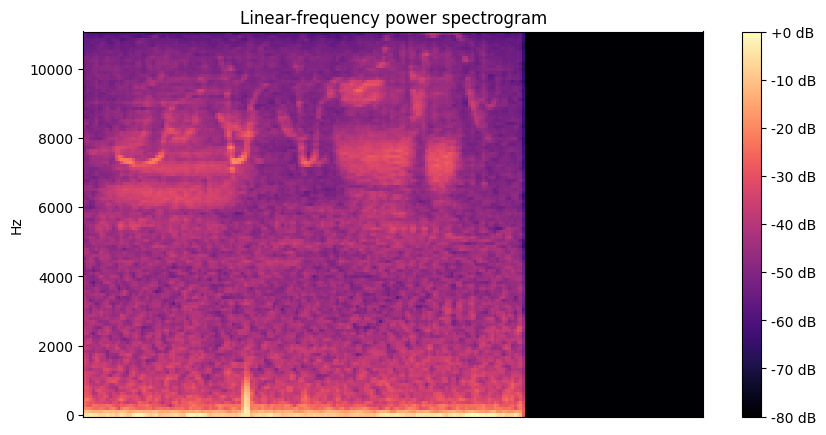

In [25]:
from utils.display import display_spectogram

display_spectogram(trainX[0])

In [15]:
def process_pipeline(model_name, specs_or_mels, seg_secs, epochs=40, batch_size=64, patience=5):
    """
    Performs the entire pipeline of processing, training, evaluating, and saving a neural network model.

    Args:
    model_name (str): The name to be used for saving the model and HTML output.
    specs_or_mels (str): Specifies whether to use spectrograms or mel spectrograms.
    seg_secs (int): The segment duration in seconds for which data is prepared.
    epochs (int, optional): The number of epochs to train the model. Defaults to 40.
    batch_size (int, optional): The batch size to use during training. Defaults to 64.
    patience (int, optional): The number of epochs with no improvement after which training will be stopped. Defaults to 5.

    Returns:
    None
    """
    # Load the data
    specs_path = f'spectrograms/{seg_secs}_secs/train_{specs_or_mels}.pkl'
    classes_path = f'spectrograms/{seg_secs}_secs/train_classes.pkl'

    trainX, trainY, _ = load_data(specs_path, classes_path)
    trainX_rgb = resize_and_convert_to_rgb(trainX)
    trainX_norm = preprocess_input(trainX_rgb)
    print(trainX_norm.shape)

    specs_path = f'spectrograms/{seg_secs}_secs/val_{specs_or_mels}.pkl'
    classes_path = f'spectrograms/{seg_secs}_secs/val_classes.pkl'

    valX, valY, _ = load_data(specs_path, classes_path)
    valX_norm = preprocess_input(valX)

    # Build the model
    num_classes = len(trainY[0])
    model = create_model(num_classes)
    history = train_model(model, trainX_norm, trainY, valX_norm, valY, epochs, batch_size, patience)

    # Create directory for saving models if it doesn't exist
    ensure_dir('models/TL')

    # Save the trained model
    model_path = os.path.join('models/TL', model_name+'.keras')
    save_model(model, model_path)

    # Load the saved model
    loaded_model = load_model(model_path)

    # Load test data and evaluate the model
    specs_path = f'spectrograms/{seg_secs}_secs/test_{specs_or_mels}.pkl'
    classes_path = f'spectrograms/{seg_secs}_secs/test_classes.pkl'

    testSegments_path = f'spectrograms/{seg_secs}_secs/test_segments.pkl'
    with open(testSegments_path, 'rb') as f:
        testSegments = np.array(pickle.load(f))


    testX, testY, encoder = load_data(specs_path, classes_path)
    testX_norm = preprocess_input(testX)
    conf_matrix, accuracy, f1, majority_conf_matrix, majority_accuracy, majority_f1 = evaluate_model(loaded_model, testX_norm, testY, testSegments)
    labels = list(encoder.classes_)

    display_model_evaluation('TL', f'input_type = {specs_or_mels} | seg_duration = {seg_secs}secs | epochs = {epochs} | batch_size = {batch_size} | patience = {patience}',\
                          history.history, accuracy, f1, conf_matrix, labels, True, majority_conf_matrix, majority_accuracy, majority_f1)

In [16]:
process_pipeline('mels_2.0_60_32_20', 'mels', '2.0', 60, 32, 20)

(224, 224, 87, 3)


ValueError: Data cardinality is ambiguous:
  x sizes: 224
  y sizes: 7490
Make sure all arrays contain the same number of samples.